### Project Brief

Suppose you have been hired as a data scientist at a used car dealership in the UK. The sales team has been having problems with pricing used cars that arrive at the dealership and would like your help. Before they take any company wide action they would like you to work with the Toyota specialist to test your idea. They have already collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

The presentation of your findings should be targeted at the Head of Sales, who has no technical data science background.

The data you will use for this analysis can be accessed here: `"toyota.csv"`

<b>Variables and their description </b>

|Variable| Description|
|----|-----|
|model| Character, the model of the car, 18 possible values|
|year| Numeric, year of manufacture from 1998 to 2020|
|price| Numeric, listed value of the car in GBP|
|transmission| Character, one of "Manual", "Automatic", "Semi-Auto" or "Other"|
|mileage| Numeric, listed milage of the car at time of sale|
|fuelType| Character, one of "Petrol", "Hybrid", "Diesel" or "Other"|
|tax| Numeric, road tax in GBP. Calculated based on CO2 emissions or a fixed price depending on the age of the car.|
|mpg| Numeric, miles per gallon as reported by manufacturer|
|engineSize| Numeric, listed engine size, one of 16 possible values|

### Table of Contents
---
* [Importing some packages](#Part0) 

* [Loading the data](#Part1) 

* [Exploratory data analysis (EDA)](#Part2)

    * [Univariate analysis](#Part21)
    
    * [Bivariate analysis](#Part22)
    
        * [Price vs numeric](#Part221)

        * [Price vs categorical](#Part222)
    
    * [Multivariate analysis](#Part23)
    
        * [Categorical-categorical vs Price](#Part231)

        * [Categorical-numeric vs Price](#Part232)

* [Feature engineering](#Part3)

* [Model estimation](#Part4)

* [Results](#Part5)

* [Conclusion](#Part6)

### Importing some packages <a name="Part0"></a>

In [1]:
!pip install optuna
!pip install pdpbox

     |████████████████████████████████| 302 kB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 208 kB 57.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 40 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 28.4 MB 60.5 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 662 kB 79.1 MB/s eta 0:00:01
     |████████████████████████████████| 15.8 MB 76.3 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 8.7 MB/s  eta 0:00:01
     |████████████████████████████████| 156 kB 88.2 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 49 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 144 kB 56.3 MB/s eta 0:00:01
     |████████████████████████████████

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor
import optuna
from pdpbox import pdp, get_dataset, info_plots

### Loading the data <a name="Part1"></a>

In [3]:
data = pd.read_csv("data/toyota.csv")

### Exploratory data analysis (EDA) <a name="Part2"></a>

#### Univariate analysis <a name="Part21"></a>

Let's start with looking through the data.

In [4]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [5]:
data.tail()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6733,IQ,2011,5500,Automatic,30000,Petrol,20,58.9,1.0
6734,Urban Cruiser,2011,4985,Manual,36154,Petrol,125,50.4,1.3
6735,Urban Cruiser,2012,4995,Manual,46000,Diesel,125,57.6,1.4
6736,Urban Cruiser,2011,3995,Manual,60700,Petrol,125,50.4,1.3
6737,Urban Cruiser,2011,4495,Manual,45128,Petrol,125,50.4,1.3


Now let's check for the data size, missing values, and data types.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


There is no missing values, as the table above shows, and the data types are ok. Let's show some descriptive stats for both categorical and numeric features.

In [7]:
data.describe(include=['object'])

,model,transmission,fuelType
count,6738,6738,6738
unique,18,4,4
top,Yaris,Manual,Petrol
freq,2122,3826,4087


In [8]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


As the table above shows that min value for tax and engineSize is 0. Maybe in case of tax it can happen, but I suspect that it's not the case for engine size. Probably the values have been missing and during data prepration they have been replaced by 0. Let's dig deeper and find out. We'll start with 0 tax case.

In [9]:
data[(data['tax']==0)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
815,Yaris,2016,11500,Automatic,31911,Hybrid,0,78.0,1.5
816,Yaris,2014,8500,Automatic,72053,Hybrid,0,76.3,1.5
820,Yaris,2016,12500,Automatic,23150,Hybrid,0,78.0,1.5
829,Yaris,2016,12695,Automatic,15945,Hybrid,0,78.0,1.5
830,Yaris,2014,10495,Automatic,29452,Hybrid,0,78.0,1.5
...,...,...,...,...,...,...,...,...,...
6318,Prius,2017,19295,Automatic,33124,Hybrid,0,85.6,1.8
6727,IQ,2009,3495,Manual,43000,Petrol,0,65.7,1.0
6728,IQ,2009,2699,Manual,74095,Petrol,0,65.7,1.0
6730,IQ,2013,4849,Manual,41142,Petrol,0,64.2,1.0


In [10]:
data[(data['tax']==0)].describe(include=['object'])

,model,transmission,fuelType
count,1790,1790,1790
unique,6,4,4
top,Aygo,Automatic,Hybrid
freq,704,1041,995


Judging by the tables above 0, in case of tax, probably represents missing values. It'll be better to replace those later in feature engineering section using KNNImputer or other technique. Now let's move to engine size.

In [11]:
data[data['engineSize']==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
2535,Yaris,2016,12300,Manual,6148,Hybrid,0,86.0,0.0
2545,Yaris,2016,11000,Automatic,39909,Hybrid,0,86.0,0.0
5126,Aygo,2019,9800,Manual,3635,Petrol,150,56.5,0.0
5233,Aygo,2019,8000,Manual,8531,Petrol,145,56.5,0.0
5257,Aygo,2019,8000,Manual,5354,Petrol,145,56.5,0.0
5960,C-HR,2017,14300,Manual,46571,Petrol,145,47.1,0.0


0 values for the engine size aren't too many. So let's try to replace those 0 values. We can use car models, year, transmission, and fuel type to find cars with similar characteristics which have engine size not equal 0. Then we can replace 0 values.
<br> Let's start with Aygo.

In [12]:
data[(data['model']==' Aygo') & 
     (data['year']==2019) & 
     (data['transmission']=='Manual') & 
     (data['fuelType']=='Petrol')]['engineSize'].unique()

array([1., 0.])

So based on the output above Aygo's engine size can be replaced by 1. Let's do that.

In [13]:
data.loc[(data['model']==' Aygo') & (data['engineSize']==0), 'engineSize'] = 1.0

Now let's deal with Yaris.

In [14]:
data[(data['model']==' Yaris') & 
     (data['year']==2016) & 
     (data['transmission']=='Manual') & 
     (data['fuelType']=='Hybrid')]['engineSize'].unique()

array([0.])

As there is no Yaris produced in 2016 with non zero engine size recorded in the data, let's look for the model with the same characteristics but different year. It'll be good to find a car produced 1 or 2 years before or after 2016. 

In [15]:
data[(data['model']==' Yaris') & 
     (data['year']==2018) & 
     (data['transmission']=='Manual') & 
     (data['fuelType']=='Hybrid')]['engineSize'].unique()

array([1.5])

So we can replace 0 engine size with 1.5 for Yaris manufactured in 2016 with manual transmission. Let's also find Yaris cars with non zero engine size again produced in 2016 but with Automatic transmission.

In [16]:
data[(data['model']==' Yaris') & 
     (data['year']==2016) & 
     (data['transmission']=='Automatic') & 
     (data['fuelType']=='Hybrid')]['engineSize'].unique()

array([1.5, 0. ])

Based on the output above we can replace 0 engine size for Yaris cars with 1.5. So let's do it.

In [17]:
data.loc[(data['model']==' Yaris') & (data['engineSize']==0), 'engineSize'] = 1.5

The final car for which we need to replace engine size is C-HR with manual transmission produced in 2017 running on Petrol. So let's find a similar car with non zero engine size.

In [18]:
data[(data['model']==' C-HR') & 
     (data['year']==2017) & 
     (data['transmission']=='Manual') & 
     (data['fuelType']=='Petrol')]['engineSize'].unique()

array([1.2, 0. ])

Well, the output above tells that we can replace 0 engine size with 1.2 for C-HR.

In [19]:
data.loc[(data['model']==' C-HR') & (data['engineSize']==0), 'engineSize'] = 1.2

There is also unnecessary space in the model names. So let's deal with that issue before moving on.

In [20]:
data['model'] = data['model'].apply(lambda x: x.strip())

Let's look the distributions of the variables.

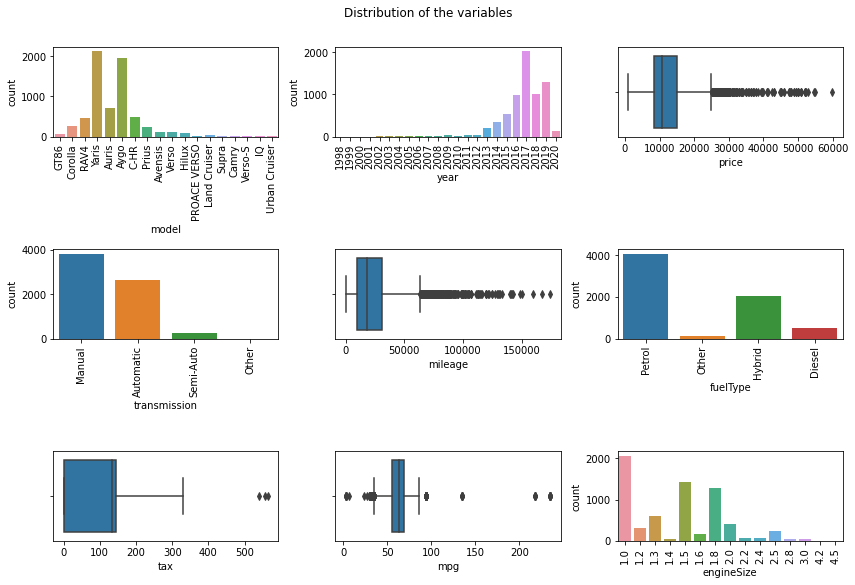

In [21]:
count_plot_var_list = ['model', 'year', 'transmission', 'fuelType', 'engineSize']
        
nrows_subplot = data.shape[1] / 3 + data.shape[1] % 3
n_subplot = 0
fig = plt.figure(figsize=(12, 8))
for col in data.columns:
    n_subplot += 1
    plt.subplot(nrows_subplot, 3, n_subplot)
    if col in count_plot_var_list:
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=90)
    else:
        sns.boxplot(x=col, data=data)
plt.suptitle('Distribution of the variables', y=1.01)
plt.tight_layout()

#### Bivariate analysis <a name="Part22"></a>

##### Price vs numeric <a name="Part221"></a>

Let's look at connection between price and the other features. But before that let's replace year column with approximate age of a car. We can get the age by subtracting year from 2021.

In [22]:
data['car_age'] = 2021 - data['year']
data.drop(columns=['year'], inplace=True)

Now let's check the correlation matrix for numeric features.

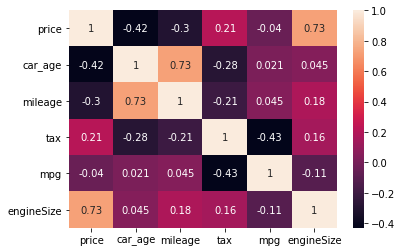

In [23]:
num_col = ['price', 'car_age', 'mileage', 'tax', 'mpg', 'engineSize']
corr_df = data[num_col].corr()
sns.heatmap(corr_df, annot=True)
plt.show()

From the heatmap above we can see that price is more or less highly correlated with engine size, car_age, mileage, and tax. Let's visualize these relationships.

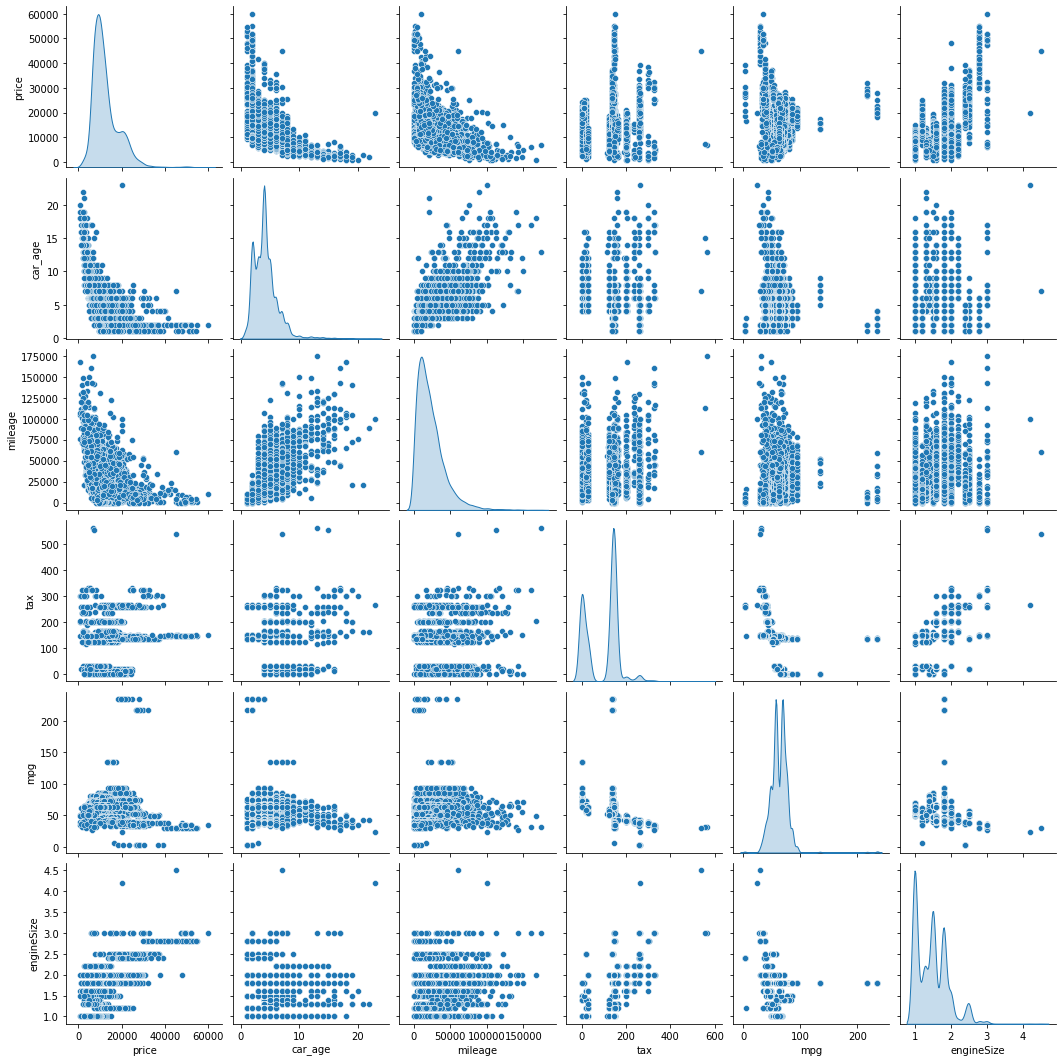

In [24]:
# nrows_subplot = (data[num_col].shape[1] - 1) / 3 + (data[num_col].shape[1] - 1) % 3
# n_subplot = 0
# fig = plt.figure(figsize=(12, 8))
# for col in num_col:
#     if col == 'price':
#         continue
#     n_subplot += 1
#     plt.subplot(nrows_subplot, 3, n_subplot)
#     sns.scatterplot(x=col, y='price', data=data)
# plt.suptitle('Price relationship with numeric features', y=1.01)
# plt.tight_layout()
sns.pairplot(data[num_col], diag_kind='kde')
plt.show()

The charts above show that maybe it would be a good idea to apply binning to tax and mpg (see relationship with price). Moreover there is negative relationship of car_age and mileage with price. There is also positive relationship between price and engineSize.
<br>Though we're going to use some tree based model, let's apply log transformation to some numeric features. Namely we'll convert price, tax, mpg, and mileage.

In [25]:
for col in ['price', 'tax', 'mpg', 'mileage']:
    data[col] = np.log(1 + data[col])

Let's use pairplot again.

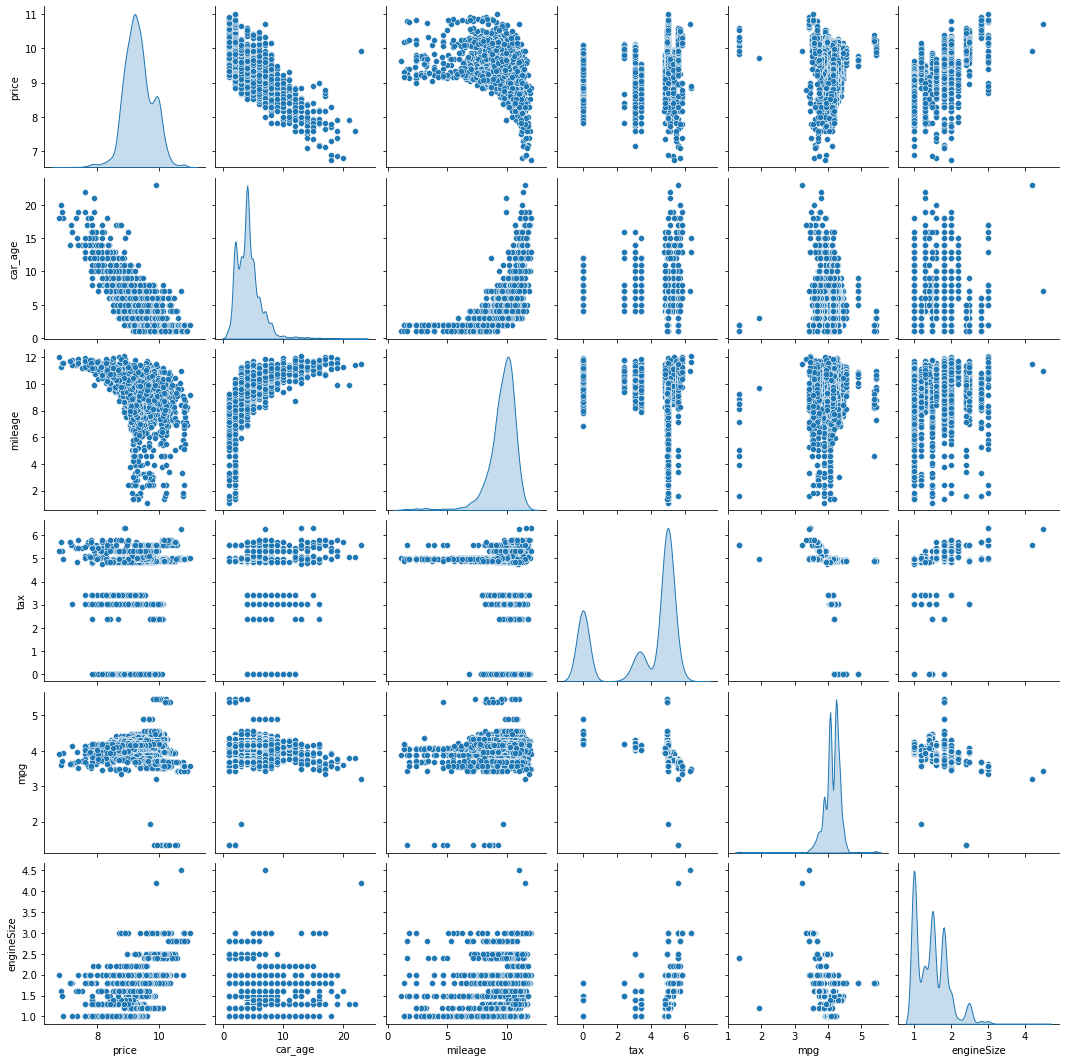

In [26]:
sns.pairplot(data[num_col], diag_kind='kde')
plt.show()

The plot below shows that there significant negative relationship between price and mileage to power of 7. So we'll create that mileage to power 7 variable later.

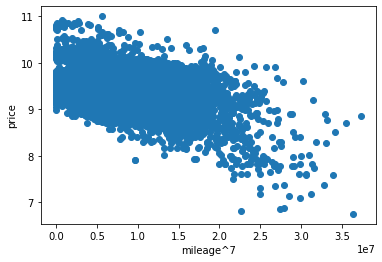

In [27]:
plt.plot(data['mileage']**7, data['price'], 'o', linestyle='None')
plt.xlabel('mileage^7')
plt.ylabel('price')
plt.show()

##### Price vs categorical <a name="Part222"></a>

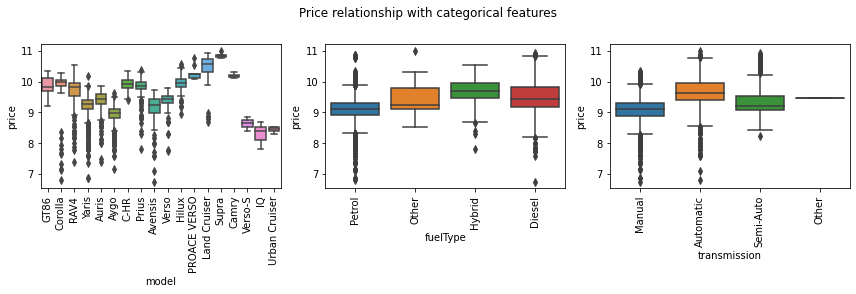

In [28]:
cat_col = ['model', 'fuelType', 'transmission']

nrows_subplot = data[cat_col].shape[1] / 3 + data[cat_col].shape[1] % 3
n_subplot = 0
fig = plt.figure(figsize=(12, 4))
for col in cat_col:
    n_subplot += 1
    plt.subplot(nrows_subplot, 3, n_subplot)
    sns.boxplot(x=col, y='price', data=data)
    plt.xticks(rotation=90)
plt.suptitle('Price relationship with categorical features', y=1.01)
plt.tight_layout()

As we can see the charts above categorical variables can be helpful as for each value in feature we notice difference in the distribution of the price. Maybe iteraction with other variables will reveal more insights. We'll see that in the next section.

### Multivariate analysis <a name="Part23"></a>

In this we'll present the relationship of price and categorical-categorical, and numeric-categorical features. So let's start the section.

##### Categorical-categorical vs Price<a name="Part231"></a>

In [29]:
def create_cat_cat_plots(cat1, cat2, data, fsize):
    '''Creates price boxplots for 2 categorical features' iteraction
    
       Params:
       cat1: str, name of the first categorical variable
       cat2: str, name of the second categorical feature
       data: dataframe, contains data for the charts
       fsize: tuple, provides overall figure size for all the charts
       
    '''
    model_names = list(data[cat1].unique())

    nrows_subplot = len(model_names) / 3 + len(model_names) % 3
    n_subplot = 0
    fig = plt.figure(figsize=fsize)
    for val in model_names:
        n_subplot += 1
        temp_data = data[data[cat1] == val]
        plt.subplot(nrows_subplot, 3, n_subplot)
        sns.boxplot(x=cat2, y='price', data=temp_data)
        plt.xticks(rotation=90)
        plt.title(f'{cat1} = {val}')
    plt.suptitle(f'Price relationship with {cat1} and {cat2}', y=1.01)
    plt.tight_layout()

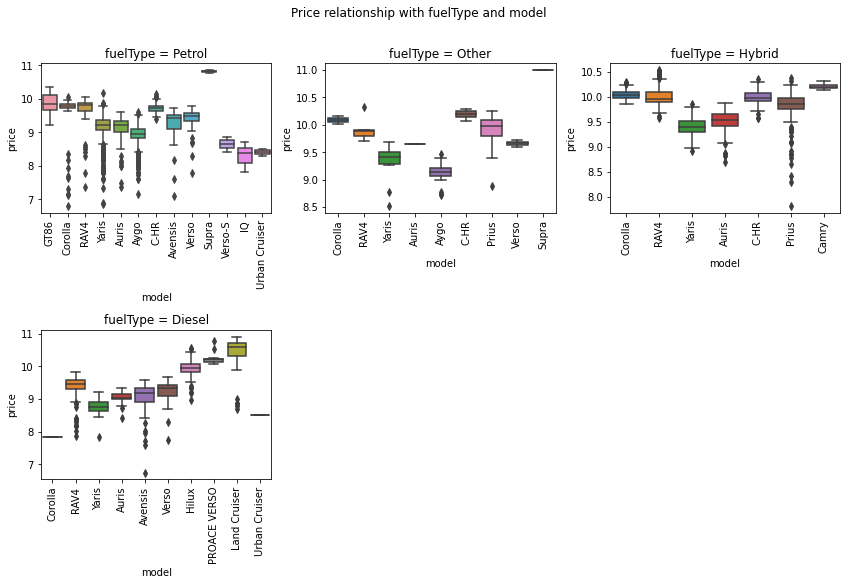

In [30]:
create_cat_cat_plots(cat1='fuelType', cat2='model', data=data, fsize = (12, 8))

It doesn't seem that model and fuel type iteraction will be handy in the prediction task. Let's move on.

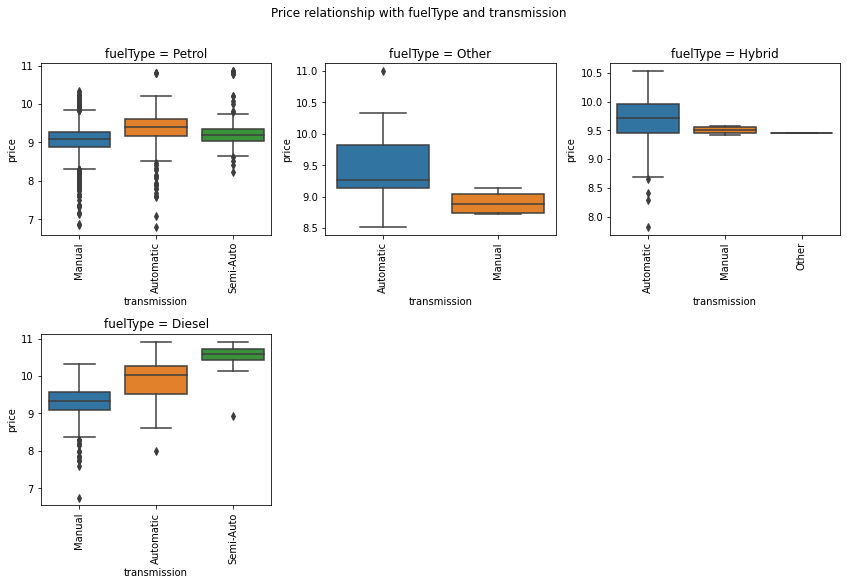

In [31]:
create_cat_cat_plots(cat1='fuelType', cat2='transmission', data=data, fsize = (12, 8))

Fuel type and transmission iteraction makes sense only in case of semi-auto transmission. It seems from the chart that among cars running on diesel semi-auto are the most expensive, which is not true in case of petrol. So let's use this to create a new feature in feature engineering section. Finally let's look at the iteraction between model and transmission.

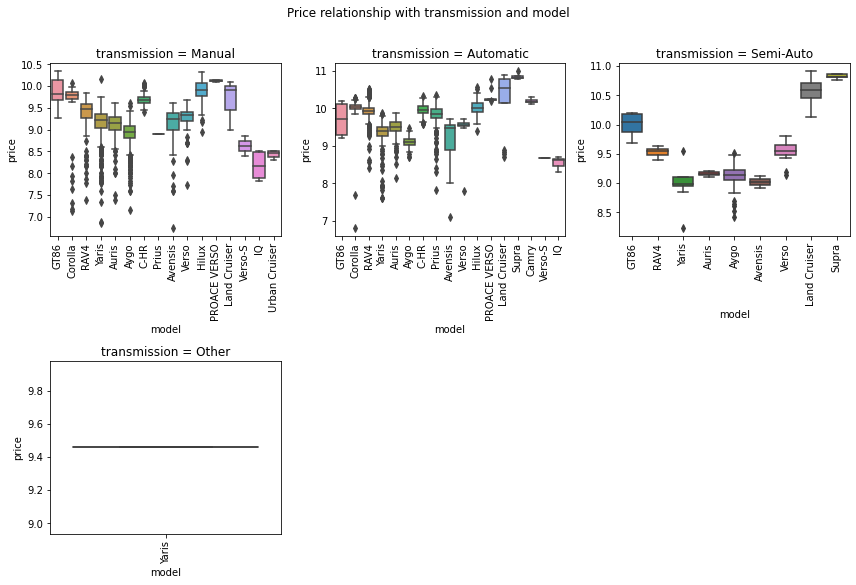

In [32]:
create_cat_cat_plots(cat1='transmission', cat2='model', data=data, fsize = (12, 8))

The iteraction above is not useful. Let's move to the numeric-numeric section.

##### Categorical-numeric vs Price <a name="Part232"></a>

In [33]:
def create_cat_num_plots(catf, num_list, data, fsize):
    '''Creates scatterplots for categorical-numerical features' iteraction with respect to price
    
       Params:
       catf: str, name of the categorical variable
       num_list: list, names of the numeric features
       data: dataframe, contains data for the charts
       fsize: tuple, provides overall figure size for all the charts
       
    '''
    nrows_subplot = len(num_list) / 3 + len(num_list) % 3
    n_subplot = 0
    fig = plt.figure(figsize=fsize)
    for col in num_list:
        n_subplot += 1
        plt.subplot(nrows_subplot, 3, n_subplot)
        sns.scatterplot(x=col, y='price', data=data, hue=catf)
    plt.suptitle(f'Price relationship with numeric features and {catf}', y=1.01)
    plt.tight_layout()

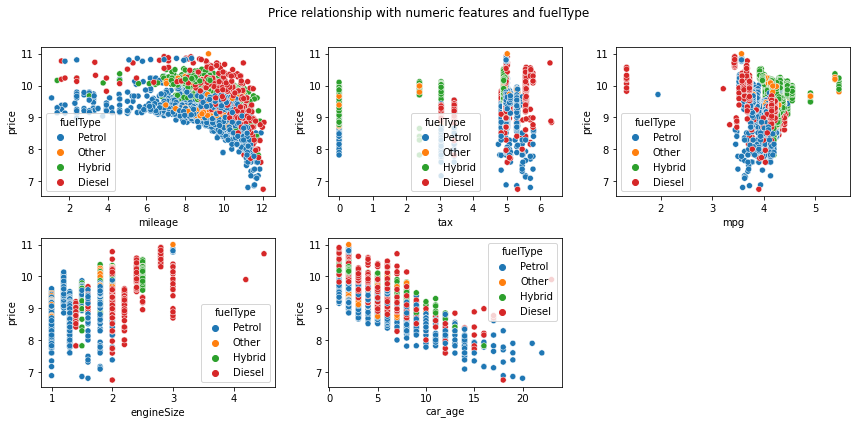

In [34]:
num_feat = ['mileage', 'tax', 'mpg', 'engineSize', 'car_age']

create_cat_num_plots(catf='fuelType', num_list=num_feat, data=data, fsize=(12, 8))

Maybe mileage and engine size iteraction with fuelType can be useful. We'll create the approapriate features later. :et's see how transmission behaves with the numeric features.

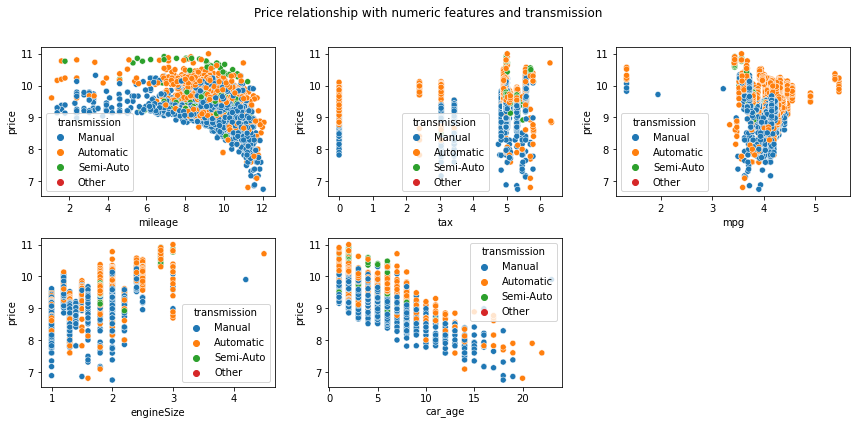

In [35]:
create_cat_num_plots(catf='transmission', num_list=num_feat, data=data, fsize=(12, 8))

Maybe mileage and car age iteraction with transmission could help.

### Feature engineering <a name="Part3"></a>

Let's start with onehot encoding for categorical features.

In [36]:
onehot_df = pd.get_dummies(data[cat_col])
data = pd.concat([data, onehot_df], axis=1)

Now let's create a feature out of mileage by raising it to power 7.

In [37]:
data['mileage7'] = data['mileage']**7

As we know from EDA section cars running on diesel with semi-auto transmission are the most expensive, but not in the case of petrol running cars. So let's create a new feature to encounter that.

In [38]:
data['diesel_iter_semi-auto'] = data['fuelType_Diesel'] * data['transmission_Semi-Auto']
data['petrol_iter_semi-auto'] = data['fuelType_Petrol'] * data['transmission_Semi-Auto']

Let's create iteraction variables for mileage and engine size with fuelType.

In [39]:
for fueltype in data['fuelType'].unique():
    data[f'mileage_iter_{fueltype}'] = data['mileage'] * data[f'fuelType_{fueltype}']
    data[f'mileage7_iter_{fueltype}'] = data['mileage7'] * data[f'fuelType_{fueltype}']
    data[f'engineSize_iter_{fueltype}'] = data['engineSize'] * data[f'fuelType_{fueltype}']

Next let's create iteraction variables for mileage and car age with transmission.

In [40]:
for t in data['transmission'].unique():
    data[f'mileage_iter_{t}'] = data['mileage'] * data[f'transmission_{t}']
    data[f'mileage7_iter_{t}'] = data['mileage7'] * data[f'transmission_{t}']
    data[f'carAge_iter_{t}'] = data['car_age'] * data[f'transmission_{t}']

Let's create bins out of mpg to create a new feature and apply onehot encoding on it.

In [41]:
data['bin_mpg'] = pd.cut(data['mpg'], bins=[0, 2, 5, np.inf], labels=False)

onehot_df = pd.get_dummies(data['bin_mpg'], prefix='mpg')
data = pd.concat([data, onehot_df], axis=1)

Now it's time to split the data into train and test sets. As some categories are oversampled in categorical features let's take that into account. Namely let's apply stratified sampling using model for stratification.

In [42]:
train_data, test_data = train_test_split(data, 
                                         test_size=0.2, 
                                         random_state=13,
                                         stratify=data[['model']])

Now we can separate the target variable from the train and test sets. Moreover let's create 5 folds out of training data using StratifiedKFold.

In [43]:
X_train = train_data[[i for i in train_data.columns
                      if i not in ['price']]].reset_index(drop=True)
y_train = train_data['price'].reset_index(drop=True)

X_test = test_data[[i for i in test_data.columns 
                    if i not in ['price']]].reset_index(drop=True)
y_test = test_data['price'].reset_index(drop=True)

skf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

fold_idx_dict = {}
fold = 0
for train_idx, val_idx in skf.split(X_train, X_train['model']):
    fold += 1
    fold_idx_dict[fold] = (list(train_idx), list(val_idx))

Let's drop fuelType, model, and transmission columns.

In [44]:
X_train.drop(columns=cat_col, inplace=True)
X_test.drop(columns=cat_col, inplace=True)

At this we can use KNNImputer to replace 0 values in the tax feature. Specifically we use out of a fold data to get tax approximation for that fold in the train set. The process will be done using the train set in case of the test set.

In [45]:
imputed_df = pd.DataFrame()
for i in range(1, 6):
    knn_imputer = KNNImputer(missing_values=0, weights='distance')
    temp_X_dev = X_train.iloc[fold_idx_dict[i][0]]['tax'].to_frame()
    temp_X_val = X_train.iloc[fold_idx_dict[i][1]]['tax'].to_frame()
    knn_imputer.fit(temp_X_dev)
    tr_X = pd.DataFrame(knn_imputer.transform(temp_X_val))
    tr_X.columns = ['imputed_tax']
    tr_X.index = fold_idx_dict[i][1]
    imputed_df = pd.concat([imputed_df, tr_X], axis=0)
    
X_train = pd.concat([X_train, imputed_df], axis=1)
X_train['tax'] = X_train['imputed_tax'].values
X_train.drop(columns=['imputed_tax'], inplace=True)
                           
knn_imputer = KNNImputer(missing_values=0, weights='distance')
knn_imputer.fit(X_train['tax'].to_frame())
tr_X = pd.DataFrame(knn_imputer.transform(X_test['tax'].to_frame()))
tr_X.columns = ['imputed_tax']
tr_X.index = X_test.index
X_test = pd.concat([X_test, tr_X], axis=1)
X_test['tax'] = X_test['imputed_tax'].values
X_test.drop(columns=['imputed_tax'], inplace=True)

### Model estimation <a name="Part4"></a>

Let's apply RandomForestRegressor and look at the importance of features.

In [86]:
rf_model = RandomForestRegressor(random_state=13)
rf_model.fit(X_train, y_train)
feat_imp_df = pd.Series(rf_model.feature_importances_, 
                        index=X_train.columns).to_frame()
feat_imp_df.columns = ['importance']
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
selected_feat = list(feat_imp_df[feat_imp_df['importance'] > 0.01].index)
feat_imp_df

,importance
engineSize,5.013808e-01
car_age,2.140398e-01
carAge_iter_Manual,1.322664e-01
mpg,4.823517e-02
tax,1.155495e-02
mileage,1.034670e-02
mileage7,9.705724e-03
model_Auris,8.626633e-03
carAge_iter_Automatic,7.254081e-03
mileage_iter_Petrol,6.485841e-03


We'll choose only features that have feature importance > 0.01. Below we observe those features.

In [87]:
selected_feat

['engineSize', 'car_age', 'carAge_iter_Manual', 'mpg', 'tax', 'mileage']

Let's find optimal values for n_estimators and max_depth for random forest using optuna.

In [88]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
    rf_model = RandomForestRegressor(n_estimators=n_estimators, 
                                     max_depth=max_depth, 
                                     random_state=13)
    cvf=[(fold_idx_dict[i][0], fold_idx_dict[i][1]) for i in range(1, 6)]
    mean_cvs = cross_val_score(rf_model, X_train[selected_feat], y_train, 
                               n_jobs=-1, cv=cvf, 
                               scoring='neg_mean_squared_error').mean()
    return mean_cvs

In [93]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2021-09-30 01:16:18,442] A new study created in memory with name: no-name-36012494-5083-4107-8b54-ad699247a13e
[I 2021-09-30 01:16:20,276] Trial 0 finished with value: -0.016256607391309262 and parameters: {'n_estimators': 84, 'max_depth': 6.123190757625881}. Best is trial 0 with value: -0.016256607391309262.
[I 2021-09-30 01:16:23,276] Trial 1 finished with value: -0.013202476418655715 and parameters: {'n_estimators': 129, 'max_depth': 7.250618405047909}. Best is trial 1 with value: -0.013202476418655715.
[I 2021-09-30 01:16:24,009] Trial 2 finished with value: -0.01093164464272433 and parameters: {'n_estimators': 15, 'max_depth': 13.860898296244486}. Best is trial 2 with value: -0.01093164464272433.
[I 2021-09-30 01:16:26,079] Trial 3 finished with value: -0.08050896209295683 and parameters: {'n_estimators': 97, 'max_depth': 2.2864412104509966}. Best is trial 2 with value: -0.01093164464272433.
[I 2021-09-30 01:16:26,474] Trial 4 finished with value: -0.012397147474923684 and para

In [94]:
trial = study.best_trial
print('RMSE: {}'.format(np.round(np.sqrt(-trial.value), 3)))
print("Best hyperparameters: {}".format(trial.params))

RMSE: 0.101
Best hyperparameters: {'n_estimators': 179, 'max_depth': 11.519497953902402}


Now let's train the random forest model on the folds.

In [95]:
fold_test_pred_rf = []
fold_val_pred_rf = []
for i in range(1, 6):
    rf_model = RandomForestRegressor(random_state=i, n_estimators=179, max_depth=12)
    rf_model.fit(X_train.iloc[fold_idx_dict[i][0]][selected_feat], 
                 y_train.iloc[fold_idx_dict[i][0]])
    y_train_pred = rf_model.predict(X_train.iloc[fold_idx_dict[i][0]][selected_feat])
    y_val_pred = rf_model.predict(X_train.iloc[fold_idx_dict[i][1]][selected_feat])
    fold_val_pred_rf.append(y_val_pred)
    y_test_pred = rf_model.predict(X_test[selected_feat])
    fold_test_pred_rf.append(rf_model.predict(X_test[selected_feat]).reshape(-1, 1))
    train_rmse = np.round(np.sqrt(mean_squared_error(y_train.iloc[fold_idx_dict[i][0]], 
                                                     y_train_pred)), 3)
    validation_rmse = np.round(np.sqrt(mean_squared_error(y_train.iloc[fold_idx_dict[i][1]], 
                                                          y_val_pred)), 3)
    test_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
    print(f'Train RMSE = {train_rmse}')
    print(f'Validation RMSE = {validation_rmse}')
    print(f'Test RMSE = {test_rmse}')
    print('-------------------------------')

Train RMSE = 0.056
Validation RMSE = 0.102
Test RMSE = 0.114
-------------------------------
Train RMSE = 0.057
Validation RMSE = 0.101
Test RMSE = 0.116
-------------------------------
Train RMSE = 0.057
Validation RMSE = 0.093
Test RMSE = 0.117
-------------------------------
Train RMSE = 0.056
Validation RMSE = 0.111
Test RMSE = 0.116
-------------------------------
Train RMSE = 0.055
Validation RMSE = 0.097
Test RMSE = 0.115
-------------------------------


Now let's get mean prediction using predictions from all cross validation folds.

In [110]:
y_test_foldm = np.hstack(fold_test_pred_rf).mean(axis=1)
ensemble_test_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_test_foldm)), 3)
print(f'Ensemble Test RMSE = {ensemble_test_rmse}')
print('-------------------------------')

isg1500_cases = np.sum(np.exp(y_test) - np.exp(y_test_foldm) > 1500)
not_good_pred_pc = np.round(100 * isg1500_cases / test_data.shape[0], 3)
print(f'In {not_good_pred_pc} % of {test_data.shape[0]} cases the predictions are above 1500 pounds.')

Ensemble Test RMSE = 0.113
-------------------------------
In 7.196 % of 1348 cases the predictions are above 1500 pounds.


### Results <a name="Part5"></a>

So we managed to get a model that predicts in around 93 % of cases the way we need. Now let's try to use partial dependecy plots to show how each chosen feature impacts the price.

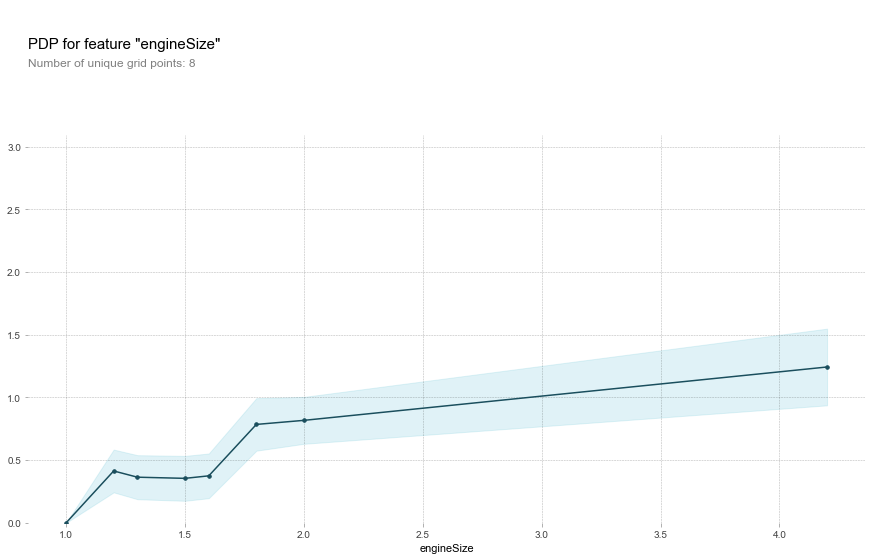

In [103]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[0])

pdp.pdp_plot(pdp_goals, selected_feat[0])
plt.show()

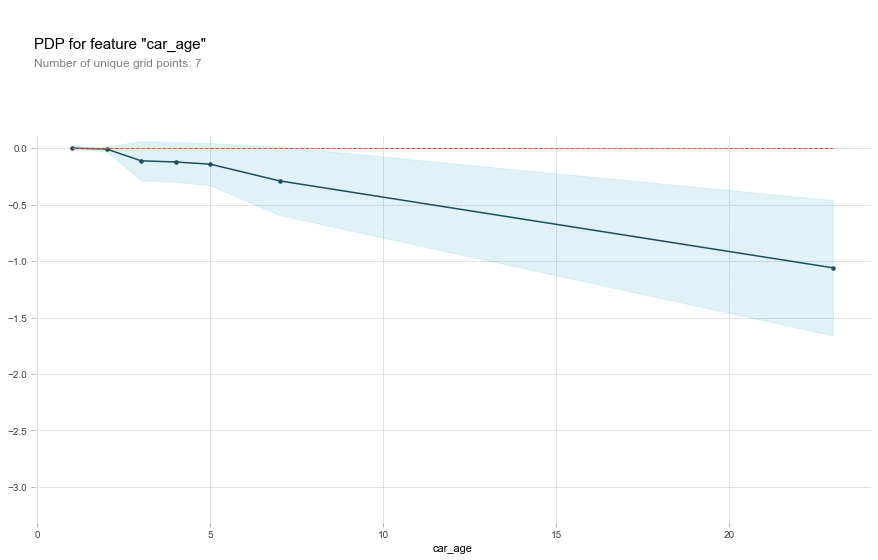

In [104]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[1])

pdp.pdp_plot(pdp_goals, selected_feat[1])
plt.show()

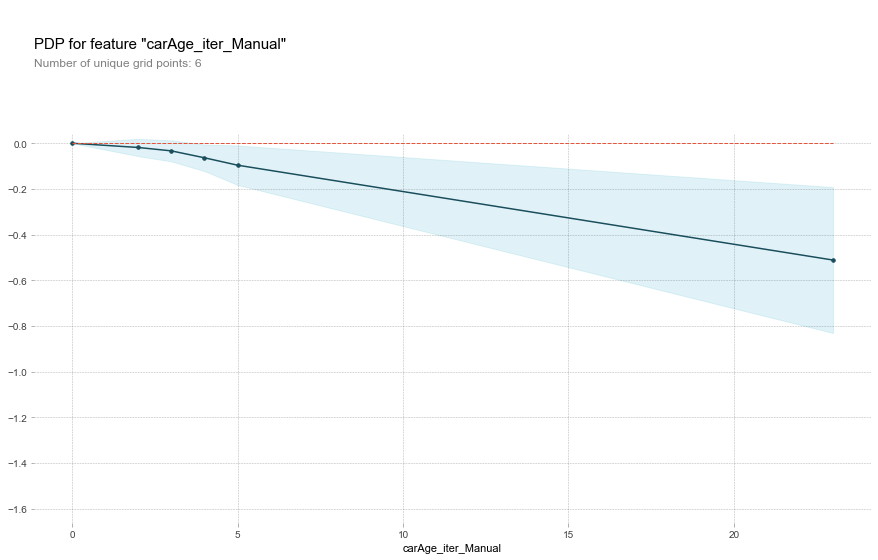

In [105]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[2])

pdp.pdp_plot(pdp_goals, selected_feat[2])
plt.show()

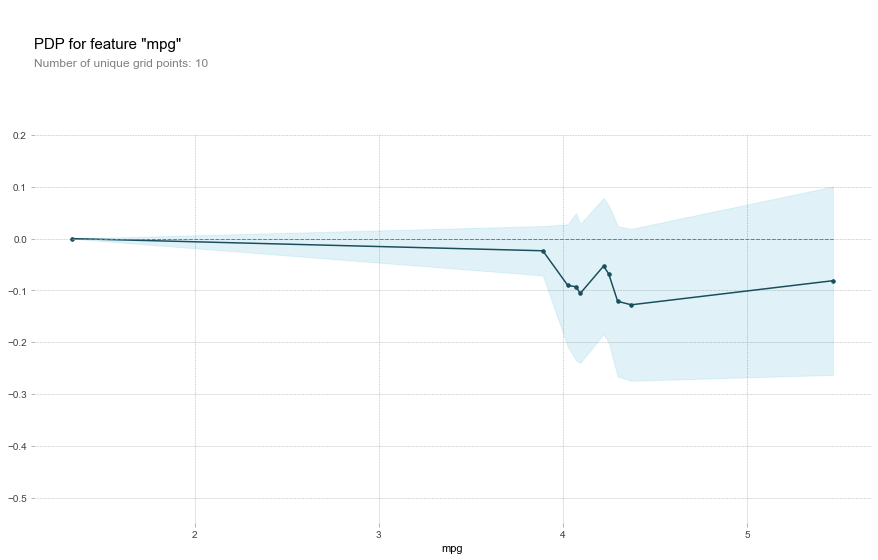

In [106]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[3])

pdp.pdp_plot(pdp_goals, selected_feat[3])
plt.show()

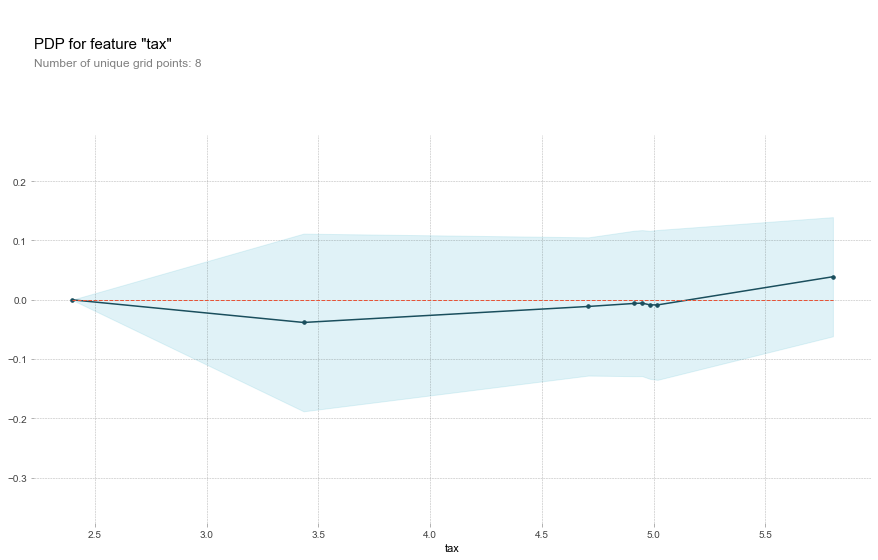

In [107]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[4])

pdp.pdp_plot(pdp_goals, selected_feat[4])
plt.show()

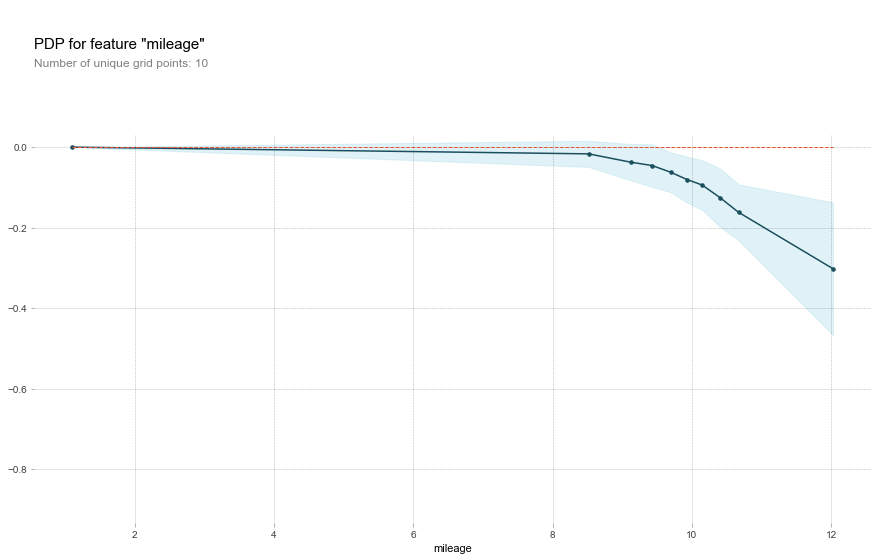

In [108]:
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=X_test, 
                            model_features=selected_feat, 
                            feature=selected_feat[5])

pdp.pdp_plot(pdp_goals, selected_feat[5])
plt.show()